In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import math
torch.manual_seed(8)
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from RealVS.AttentiveLayers import Fingerprint, Discriminator
from RealVS import Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

In [3]:
from RealVS.utils import EarlyStopping
from RealVS.utils import Meter

In [4]:
Target_GPCR_Active_Ligands = "../Benchmark_Datasets/Task_ID_9/Target_GPCR_Active_Ligands.csv"
Souce_GPCR_Ligans = "../Benchmark_Datasets/Task_ID_9/Souce_A_GPCR_Ligans.csv"
Test_Set = "../Benchmark_Datasets/Task_ID_9/Test_Set.csv"
Active_Ligands_in_the_Test_Set = 50
batch_size = 10
total_epoch = 1000
file_list1 = Target_GPCR_Active_Ligands.split('/')
file1 = file_list1[-2]
file_list2 = Souce_GPCR_Ligans.split('/')
file2 = file_list2[-1]
file2 = file2[6:7]
model_file = "RealVS_Models/"+file1+'_'+file2
print(model_file)

RealVS_Models/Task_ID_9_A


In [5]:
tasks = ['value']
feature_filename = Target_GPCR_Active_Ligands.replace('.csv','.pickle')
filename = Target_GPCR_Active_Ligands.replace('.csv','')
prefix_filename = Target_GPCR_Active_Ligands.split('/')[-1].replace('.csv','')
Training_Set = pd.read_csv(Target_GPCR_Active_Ligands, header=0, names = ["smiles","value","cano_smiles"],usecols=[0,1,2])

print(Training_Set[:5])
def add_canonical_smiles(Training_Set):
    smilesList = Training_Set.smiles.values
    print("number of all smiles: ",len(smilesList))
    atom_num_dist = []
    remained_smiles = []
    canonical_smiles_list = []
    for smiles in smilesList:
        try:        
            mol = Chem.MolFromSmiles(smiles)
            atom_num_dist.append(len(mol.GetAtoms()))
            remained_smiles.append(smiles)
            canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        except:
            print(smiles)
            pass
    print("number of successfully processed smiles: ", len(remained_smiles))
    Training_Set = Training_Set[Training_Set["smiles"].isin(remained_smiles)]
    Training_Set['cano_smiles'] =canonical_smiles_list
    return Training_Set

                                              smiles     value  \
0  C1CN(CCN1CC2=CSC(=C2C(=O)C3=CC=C(C=C3)Cl)N)C4=... -0.161368   
1  C1CN(CCN1CC2=CSC(=C2C(=O)C3=CC=C(C=C3)Cl)N)C4=... -0.161368   
2  CCCCN1C(=O)C2=C(N=C(N2)C34CC5CC(C3)CC4C5)N(C1=...  0.193142   
3  C1CN(CCN1CC2=CSC(=C2C(=O)C3=CC=C(C=C3)Cl)N)C4=... -0.161368   
4         C1CCC2=C(C1)C(=C(S2)N)C(=O)C3=CC=C(C=C3)Cl -3.662758   

                                         cano_smiles  
0  Nc1scc(CN2CCN(c3ccc(C(F)(F)F)cc3)CC2)c1C(=O)c1...  
1     Nc1scc(CN2CCN(c3ccccc3)CC2)c1C(=O)c1ccc(Cl)cc1  
2  CCCCn1c(=O)c2[nH]c(C34CC5CC(CC3C5)C4)nc2n(CCCO...  
3     Nc1scc(CN2CCN(c3ccccn3)CC2)c1C(=O)c1ccc(Cl)cc1  
4                  Nc1sc2c(c1C(=O)c1ccc(Cl)cc1)CCCC2  


In [6]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
random_seed = 68

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
Source_Dataset = pd.read_csv(Souce_GPCR_Ligans,header=0,names=["smiles"],usecols=[3])
Source_Dataset = add_canonical_smiles(Source_Dataset)
Source_Dataset['value'] = -4.1
print(Source_Dataset.head())
print(Source_Dataset[-10:])

number of all smiles:  13
number of successfully processed smiles:  13
                                              smiles  \
0  CCCCC(C(=O)NC(CC1=CC=C(C=C1)O)C(=O)NC(CCCCN)C(...   
1  CCCCC(C(=O)NC(CC1=CC(=C(C=C1)F)F)C(=O)NC(CCCCN...   
2  C1CC(N(C1)C(=O)CCCCCNC(=O)C2CCC3C4=C(CCN3C2)C5...   
3                       CN1C=NC2=C1C(=O)N(C(=O)N2C)C   
4  C1CC(N(C1)C(=O)CCCCCNC(=O)C2CCC3C4=C(CCN3C2)C5...   

                                         cano_smiles  value  
0  CCCCC(NC(=O)C1CCC2c3[nH]c4ccccc4c3CCN2C1)C(=O)...   -4.1  
1  CCCCC(NC(=O)C1CCC2c3[nH]c4ccccc4c3CCN2C1)C(=O)...   -4.1  
2  NCCCCC(NC(=O)C(Cc1c[nH]c2ccccc12)NC(=O)C1CCCN1...   -4.1  
3                         Cn1c(=O)c2c(ncn2C)n(C)c1=O   -4.1  
4  NCCCCC(NC(=O)C(Cc1ccc(F)c(F)c1)NC(=O)C1CCCN1C(...   -4.1  
                                               smiles  \
3                        CN1C=NC2=C1C(=O)N(C(=O)N2C)C   
4   C1CC(N(C1)C(=O)CCCCCNC(=O)C2CCC3C4=C(CCN3C2)C5...   
5   CCCCC(C(=O)NC(CC1=CNC2=CC=CC=C21)C(=O)N3CC(CC

In [8]:
Test_Dataset = pd.read_csv(Test_Set,header=0,names=["smiles","value","cano_smiles"],usecols=[0,1,2])
print(Test_Dataset.head())

                                              smiles     value  \
0  CCCN1C2=C(C(=O)N(C1=O)CCC)NC(=N2)NC(=O)C3=CC(=...  0.102373   
1  CCCN1C(=O)C2=C(N=C(N2)C3CC4CCC3C4)N(C1=O)CCCCC...  0.327902   
2         CCCN1C2=C(C(=O)N(C1=O)CCC)NC(=N2)NC(=O)CBr -0.113943   
3  CCCN1C(=O)C2=C(N=C(N2)C3CCCC3)N(C1=O)CCCNC(=O)...  0.508638   
4  [B-]1(N2C(=CC=C2C=CC3=CC=C(C=C3)OCC(=O)NCCCCNC... -1.210051   

                                         cano_smiles  
0  CCCn1c(=O)c2[nH]c(NC(=O)c3cccc(S(=O)(=O)F)c3)n...  
1  CCCn1c(=O)c2[nH]c(C3CC4CCC3C4)nc2n(CCCCC(=O)c2...  
2          CCCn1c(=O)c2[nH]c(NC(=O)CBr)nc2n(CCC)c1=O  
3  CCCn1c(=O)c2[nH]c(C3CCCC3)nc2n(CCCNC(=O)c2ccc(...  
4  CCNC(=O)C1OC(n2cnc3c(NCCCCNC(=O)COc4ccc(C=Cc5c...  


In [9]:
total_df = pd.concat([Training_Set,Source_Dataset,Test_Dataset],axis=0)
total_smilesList = total_df['smiles'].values
print(len(total_smilesList))
feature_dicts = save_smiles_dicts(total_smilesList,filename)
remained_df = total_df[total_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
Training_Set = Training_Set[Training_Set["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
Source_Dataset = Source_Dataset[Source_Dataset["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
Test_Dataset = Test_Dataset[Test_Dataset["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
Training_Set = Training_Set.reset_index(drop=True)
Source_Dataset = Source_Dataset.reset_index(drop=True)
Test_Dataset = Test_Dataset.reset_index(drop=True)

114
feature dicts file saved as ./Benchmark_Datasets/Task_ID_9/Target_GPCR_Active_Ligands.pickle


In [10]:
Validation_Set_active = Training_Set.sample(frac=0.2,random_state=random_seed)
Training_Set = Training_Set.drop(Validation_Set_active.index)
Training_Set = Training_Set.reset_index(drop=True)
Validation_Set_inactive = Source_Dataset.sample(frac=0.2,random_state=random_seed)
Source_Dataset = Source_Dataset.drop(Validation_Set_inactive.index)
Source_Dataset = Source_Dataset.reset_index(drop=True)
Validation_Set = pd.concat([Validation_Set_active,Validation_Set_inactive],axis=0)
Validation_Set = Validation_Set.reset_index(drop=True)

In [11]:
print(Training_Set.shape,Validation_Set.shape,Source_Dataset.shape,Test_Dataset.shape)

(30, 3) (11, 3) (10, 3) (63, 3)


In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([remained_df["cano_smiles"].values[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
max_epoch = 1000
batch_size = 10
model_binary = Discriminator(fingerprint_dim,max_iter=1e6)
model_binary.cuda()
model_binary1 = Discriminator(fingerprint_dim,max_iter=1e6)
model_binary1.cuda()

optimizer = optim.Adam([
{'params': model.parameters(), 'lr': 10**(-learning_rate), 'weight_decay ': 10**-weight_decay}, 
{'params': model_binary.parameters(), 'lr': 10**-learning_rate, 'weight_decay ': 10**-weight_decay},
{'params': model_binary1.parameters(), 'lr': 10**-learning_rate, 'weight_decay ': 10**-weight_decay}
])

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [13]:
import numpy as np
from matplotlib import pyplot as plt

def plot_output(active,inactive,epoch):
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    x_a = np.arange(0,len(active),1)
    plt.plot(x_a,active,marker='.')
    plt.ylabel('binary_active')
    plt.title("epoch: {}, mean_value: {}".format(epoch,np.mean(active)))
    plt.subplot(1,2,2)
    x_ina = np.arange(0,len(inactive),1)
    plt.plot(x_ina,inactive,marker='.')
    plt.ylabel('binary_inactive')
    plt.title("epoch: {}, mean_value: {}".format(epoch,np.mean(inactive)))
    plt.show()
    

def sorted_show_pik(dataset, p, k, k_predict, i, acc):
    p_value = dataset[tasks[0]].astype(float).tolist()
    x = np.arange(0,len(dataset),1)
    plt.scatter(x,p,marker='.',s=6,color='r',label='predict')
    plt.scatter(x,p_value,s=6,marker=',',color='blue',label='p_value')
    plt.axvline(x=k-1,ls="-",c="black")
    k_value = np.ones(len(dataset))
    k_value = k_value*k_predict
    plt.plot(x,k_value,'-',color='black')
    plt.ylabel('p_value')
    plt.title("epoch: {},  top-k recall: {}".format(i,acc))
    plt.legend(loc=3,fontsize=5)
    plt.show()
    


def topk_acc2(df, predict, k, show_flag, i):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) 
    df3 = df2[:k]
    
    true_sort = df.sort_values(by=tasks[0],ascending=False)
    k_true = true_sort[tasks[0]].values[k-1]
    acc = len(df3[df3[tasks[0]].values>=k_true])/k 
    fp = len(df3[df3[tasks[0]].values==-4.1])/k 
    
    if(show_flag):
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

def topk_recall(df, predict, k, active_num, show_flag, i):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False)
    df3 = df2[:k]
    df4 = df2[:active_num]
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) 
    min_active = true_sort[tasks[0]].values[active_num-1] 
    
    if active_num == 0:
        acc = 0
    else:
        acc = len(df3[df3[tasks[0]].values>=min_active])/active_num
    fp = len(df4[df4[tasks[0]].values==-4.1])/k 
    
    if(show_flag):
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

    
def topk_acc_recall(df, predict, k, active_num, show_flag, i):
    if k>active_num:
        return topk_recall(df, predict, k, active_num, show_flag, i)
    return topk_acc2(df,predict,k,show_flag,i)

In [14]:
def caculate_r2(y,predict):
    y = torch.FloatTensor(y).reshape(-1,1)
    predict = torch.FloatTensor(predict).reshape(-1,1)
    y_mean = torch.mean(y)
    predict_mean = torch.mean(predict)
    
    y1 = torch.pow(torch.mm((y-y_mean).t(),(predict-predict_mean)),2)
    y2 = torch.mm((y-y_mean).t(),(y-y_mean))*torch.mm((predict-predict_mean).t(),(predict-predict_mean))
    return y1/y2

In [15]:
def topk_acc_weighted(df, predict, val_active_num):
    weighted_acc_list=[]
    for k in np.arange(1,len(df),1):
        acc, fp = topk_acc_recall(df, predict, k, val_active_num, False, 0)
        weight = (len(df)-k)/len(df)
        weighted_acc_list.append(acc*weight)#
    weighted_acc_list = np.array(weighted_acc_list)
    return np.sum(weighted_acc_list)/weighted_acc_list.shape[0]

In [16]:
def train(model, model_binary, model_binary1, dataset, source_dataset, Test_Dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    max_len = np.max([dataset.shape[0],source_dataset.shape[0], Test_Dataset.shape[0]])
    valList = np.arange(0,max_len)
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, max_len, batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch%dataset.shape[0],:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values.astype(float)
        source_batch_df = source_dataset.loc[batch%source_dataset.shape[0],:]
        source_smiles_list = source_batch_df.cano_smiles.values
        y_binary = source_batch_df[tasks[0]].values.astype(float)
        test_batch_df = Test_Dataset.loc[batch%Test_Dataset.shape[0],:]
        test_smiles_list = test_batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_feature, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_feature=True)
        x_atom1, x_bonds1, x_atom_index1, x_bond_index1, x_mask1, smiles_to_rdkit_list1 = get_smiles_array(source_smiles_list,feature_dicts)
        mol_feature_source, mol_prediction_source = model(torch.Tensor(x_atom1),torch.Tensor(x_bonds1),torch.cuda.LongTensor(x_atom_index1),torch.cuda.LongTensor(x_bond_index1),torch.Tensor(x_mask1),output_feature=True) 
        x_atom2, x_bonds2, x_atom_index2, x_bond_index2, x_mask2, smiles_to_rdkit_list2 = get_smiles_array(test_smiles_list,feature_dicts)
        mol_feature_test, mol_prediction_test = model(torch.Tensor(x_atom2),torch.Tensor(x_bonds2),torch.cuda.LongTensor(x_atom_index2),torch.cuda.LongTensor(x_bond_index2),torch.Tensor(x_mask2),output_feature=True)

        source_features = torch.cat((mol_feature, mol_feature_source), dim=0)
        source_binary = model_binary1(source_features,reverse=True)
        target_binary = model_binary1(mol_feature_test,reverse=True)
        train_binary = model_binary(mol_feature_source)
        val_binary = model_binary(mol_feature)
        regression_loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))
        adversarial_loss = nn.BCELoss()(source_binary, torch.ones_like(source_binary))+nn.BCELoss()(target_binary, torch.zeros_like(target_binary))
        classification_loss = nn.BCELoss()(train_binary, torch.zeros_like(train_binary))+nn.BCELoss()(val_binary, torch.ones_like(val_binary))
        
        optimizer.zero_grad()
        loss = regression_loss + adversarial_loss + classification_loss
        loss.backward()
        optimizer.step()
        
def eval(model, model_binary, dataset):
    model.eval()
    predict_list = []
    test_MSE_list = []
    binary_output_list = []
    r2_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = [] 
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
    
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_feature, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_feature=True)
        binary_output = model_binary(mol_feature).cpu().detach().numpy()
        binary_output_list.extend(binary_output)
        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        predict_list.extend(mol_prediction.cpu().detach().numpy())
        test_MSE_list.extend(MSE.data.view(-1,1).cpu().numpy())
    
    return caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list, binary_output_list


In [17]:
import matplotlib.pyplot as plt
def plot_hist(test_binary_output_a,test_binary_output_ina,flag):
    if flag:
        return
    test_binary_output_a = np.array(test_binary_output_a)
    test_binary_output_ina = np.array(test_binary_output_ina)
    weights_a = np.ones_like(test_binary_output_a) / len(test_binary_output_a)
    weights_ina = np.ones_like(test_binary_output_ina) / len(test_binary_output_ina)

    ax = plt.subplot(1,2,1)
    plt.hist(test_binary_output_a,bins=np.arange(0,1.01,0.1),weights=weights_a)
    plt.xlim(0,1)
    ax.set_title("test_binary_output_a")

    ax = plt.subplot(1,2,2)
    plt.hist(test_binary_output_ina,bins=np.arange(0,1.01,0.1),weights=weights_ina)
    plt.xlim(0,1)
    ax.set_title("test_binary_output_ina")
    plt.show()

def caculate_binary_acc(test_binary_output_a,test_binary_output_ina,test_binary_output):
    acc = (len(test_binary_output_a[test_binary_output_a>0.5])+len(test_binary_output_ina[test_binary_output_ina<0.5]))/len(test_binary_output)
    return acc

epoch: 1 R2:0.1405 0.3141 RMSE:1.2659 1.5797 weighted_acc:0.0000
epoch: 2 R2:0.1672 0.3221 RMSE:1.2175 1.7618 weighted_acc:0.0000
epoch: 3 R2:0.2044 0.3335 RMSE:1.2407 1.9505 weighted_acc:0.5000
epoch: 4 R2:0.1975 0.3309 RMSE:1.1970 1.7680 weighted_acc:0.2439
epoch: 5 R2:0.2046 0.3299 RMSE:1.1877 1.7064 weighted_acc:0.2679
epoch: 6 R2:0.2309 0.3272 RMSE:1.1731 1.7747 weighted_acc:0.2921
epoch: 7 R2:0.2562 0.3295 RMSE:1.1629 1.8159 weighted_acc:0.2512
epoch: 8 R2:0.2576 0.3254 RMSE:1.1476 1.7158 weighted_acc:0.2512
epoch: 9 R2:0.2826 0.3175 RMSE:1.1306 1.7425 weighted_acc:0.2383
epoch: 10 R2:0.3289 0.3012 RMSE:1.1213 1.8622 weighted_acc:0.3044
epoch: 11 R2:0.3486 0.3006 RMSE:1.1094 1.8699 weighted_acc:0.2224
epoch: 12 R2:0.3387 0.3106 RMSE:1.0890 1.7555 weighted_acc:0.2233
epoch: 13 R2:0.4124 0.2655 RMSE:1.0881 1.9238 weighted_acc:0.2233
EarlyStopping counter: 1 out of 30
EarlyStopping counter: 1 out of 30
epoch: 14 R2:0.3994 0.3021 RMSE:1.0579 1.8069 weighted_acc:0.2233
EarlyStopping c

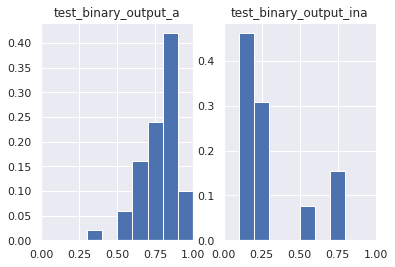

50
----------
46 R2:0.7042 0.2075 0.1722 RMSE:0.7756 1.7661 1.5912
tensor([[0.2563]], device='cpu') 1.2525644


In [18]:
train_mse_list=[]
train_r2_list=[]
test_mse_list=[]
test_r2_list=[]
val_mse_list=[]
val_r2_list=[]

epoch = 0
k_list = [int(len(Test_Dataset)*0.01),int(len(Test_Dataset)*0.1),50,100,150,200,250,300]
stopper = EarlyStopping(mode='higher', patience=30, filename=model_file + '_Regression_Model.pth')
stopper_binary = EarlyStopping(mode='higher', patience=30, filename=model_file + '_Classification_Model.pth')
while epoch < max_epoch:
    epoch = epoch + 1
    train(model, model_binary, model_binary1, Training_Set, Source_Dataset, Test_Dataset, optimizer, loss_function)
    train_r2, train_MSE, train_predict, train_binary_output = eval(model,model_binary, Training_Set)
    val_r2, val_MSE, val_predict, val_binary_output = eval(model,model_binary, Validation_Set)
    val_predict = np.array(val_predict)
    val_binary_output = np.array(val_binary_output)
    val_binary_active_num = len(val_binary_output[val_binary_output>0.5])
    val_active_num = val_binary_active_num if val_binary_active_num<len(Validation_Set_active) else len(Validation_Set_active)
    val_predict[val_binary_output<0.5] = -4.1
    
    val_topk_list =[]
    val_false_positive_rate_list = []
    weighted_acc = topk_acc_weighted(Validation_Set, val_predict, val_active_num)
    
    train_mse_list.append(train_MSE**0.5)
    train_r2_list.append(train_r2)
    val_mse_list.append(val_MSE**0.5)  
    val_r2_list.append(val_r2)
    print('epoch:',epoch, 'R2:%.4f'%train_r2,'%.4f'%val_r2, 'RMSE:%.4f'%train_MSE**0.5, '%.4f'%val_MSE**0.5,'weighted_acc:%.4f'%weighted_acc)
    if epoch > 10:
        early_stop = stopper.step(weighted_acc, model)
        early_stop_binary = stopper_binary.step(weighted_acc, model_binary)
        if early_stop:
            break

stopper.load_checkpoint(model)
stopper_binary.load_checkpoint(model_binary)
    
test_r2, test_MSE, test_predict, test_binary_output = eval(model, model_binary, Test_Dataset)
test_r2_a, test_MSE_a, test_predict_a, test_binary_output_a = eval(model, model_binary, Test_Dataset[:Active_Ligands_in_the_Test_Set])
test_r2_ina, test_MSE_ina, test_predict_ina, test_binary_output_ina = eval(model, model_binary, Test_Dataset[Active_Ligands_in_the_Test_Set:].reset_index(drop=True))
    
test_predict = np.array(test_predict)
test_binary_output = np.array(test_binary_output)
test_binary_output_a = np.array(test_binary_output_a)
test_binary_output_ina = np.array(test_binary_output_ina)

test_predict_screened = test_predict
binary_active_num = len(test_predict_screened[test_binary_output>0.5])

test_predict_screened[test_binary_output<0.5] = -4.1
binary_acc = caculate_binary_acc(test_binary_output_a,test_binary_output_ina,test_binary_output)

plot_hist(test_binary_output_a,test_binary_output_ina,False)

k_list = [int(len(Test_Dataset)*0.05),int(len(Test_Dataset)*0.1),int(len(Test_Dataset)*0.15),int(len(Test_Dataset)*0.2),int(len(Test_Dataset)*0.25),
          int(len(Test_Dataset)*0.3),int(len(Test_Dataset)*0.4),int(len(Test_Dataset)*0.5),50,100,150,200,250,300]
topk_list =[]
false_positive_rate_list = []
active_num = binary_active_num if binary_active_num<Active_Ligands_in_the_Test_Set else Active_Ligands_in_the_Test_Set
print(active_num)
for k in k_list:
    a,b = topk_acc_recall(Test_Dataset, test_predict_screened, k, active_num, False, epoch)
    topk_list.append(a)
    false_positive_rate_list.append(b)

print("----------")
print(epoch, 'R2:%.4f'%train_r2,'%.4f'%val_r2,'%.4f'%test_r2, 'RMSE:%.4f'%train_MSE**0.5, '%.4f'%val_MSE**0.5, '%.4f'%test_MSE**0.5)
print(test_r2_a, test_MSE_a)

In [19]:
print(' epoch:',epoch,'r2:%.4f'%test_r2_a,'RMSE:%.4f'%test_MSE_a,'\n','\n',
      'Top-5:%.4f'%topk_list[0],'Top-5-fp:%.4f'%false_positive_rate_list[0],'\n',
      'Top-10:%.4f'%topk_list[1],'Top-10-fp:%.4f'%false_positive_rate_list[1],'\n',
      'Top-15:%.4f'%topk_list[2],'Top-15-fp:%.4f'%false_positive_rate_list[2],'\n',
      'Top-20:%.4f'%topk_list[3],'Top-20-fp:%.4f'%false_positive_rate_list[3],'\n',
      'Top-25:%.4f'%topk_list[4],'Top-25-fp:%.4f'%false_positive_rate_list[4],'\n',
      'Top-30:%.4f'%topk_list[5],'Top-30-fp:%.4f'%false_positive_rate_list[5],'\n',
      'Top-40:%.4f'%topk_list[6],'Top-40-fp:%.4f'%false_positive_rate_list[6],'\n',
      'Top-50:%.4f'%topk_list[7],'Top-50-fp:%.4f'%false_positive_rate_list[7],'\n','\n',
      'Top50:%.4f'%topk_list[8],'Top50-fp:%.4f'%false_positive_rate_list[8],'\n',
      'Top100:%.4f'%topk_list[9],'Top100-fp:%.4f'%false_positive_rate_list[9],'\n',
      'Top150:%.4f'%topk_list[10],'Top150-fp:%.4f'%false_positive_rate_list[10],'\n',
      'Top200:%.4f'%topk_list[11],'Top200-fp:%.4f'%false_positive_rate_list[11],'\n',
      'Top250:%.4f'%topk_list[12],'Top250-fp:%.4f'%false_positive_rate_list[12],'\n',
      'Top300:%.4f'%topk_list[13],'Top300-fp:%.4f'%false_positive_rate_list[13],'\n','\n',
      'binary_acc:%.4f'%binary_acc)

 epoch: 46 r2:0.2563 RMSE:1.2526 
 
 Top-5:0.0000 Top-5-fp:0.0000 
 Top-10:0.3333 Top-10-fp:0.0000 
 Top-15:0.5556 Top-15-fp:0.0000 
 Top-20:0.6667 Top-20-fp:0.0000 
 Top-25:0.7333 Top-25-fp:0.0000 
 Top-30:0.7222 Top-30-fp:0.1111 
 Top-40:0.7600 Top-40-fp:0.0800 
 Top-50:0.7419 Top-50-fp:0.0645 
 
 Top50:0.9400 Top50-fp:0.0600 
 Top100:1.0000 Top100-fp:0.0300 
 Top150:1.0000 Top150-fp:0.0200 
 Top200:1.0000 Top200-fp:0.0150 
 Top250:1.0000 Top250-fp:0.0120 
 Top300:1.0000 Top300-fp:0.0100 
 
 binary_acc:0.9365


In [20]:
print(Target_GPCR_Active_Ligands)
print(Souce_GPCR_Ligans)
print(Test_Set)

./Benchmark_Datasets/Task_ID_9/Target_GPCR_Active_Ligands.csv
./Benchmark_Datasets/Task_ID_9/Souce_A_GPCR_Ligans.csv
./Benchmark_Datasets/Task_ID_9/Test_Set.csv
